# imports

In [ ]:
!pip install langdetect
from langdetect import detect


In [ ]:
!pip install firebase-admin

In [ ]:
import firebase_admin
from firebase_admin import credentials, firestore

if not firebase_admin._apps:
    cred = credentials.Certificate("sentimentm.json")
    firebase_admin.initialize_app(cred)

db = firestore.client()

In [ ]:
from datetime import datetime

doc_ref = db.collection("news_analysis").document()
doc_ref.set({
    "title": "TEST: Bitcoin price update",
    "sentiment_label": "POSITIVE",
    "sentiment_score": 0.87,
    "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "source": "automated_script"
})

print("✅ Check Firebase Console → Firestore → news_analysis for new document!")

✅ Check Firebase Console → Firestore → news_analysis for new document!


In [ ]:
# This will auto-create the 'news_analysis' collection with documents
test_ref = db.collection("news_analysis").document("test_doc")
test_ref.set({
    "title": "Test News",
    "sentiment_label": "NEUTRAL",
    "sentiment_score": 0.5,
    "timestamp": firestore.SERVER_TIMESTAMP
})

update_time {
  seconds: 1748374193
  nanos: 567000
}
transform_results {
  timestamp_value {
    seconds: 1748374192
    nanos: 979000000
  }
}

# code

In [ ]:
import requests
import time
from getpass import getpass
import requests
import time

API_KEY = getpass('Enter your NewsAPI key: ')
QUERY = "bitcoin"
PAGE_SIZE = 100
MAX_ARTICLES = 299

all_articles = []
page = 1

url = f"https://newsapi.org/v2/everything?q={QUERY}&pageSize={PAGE_SIZE}&page={page}&apiKey={API_KEY}"
response = requests.get(url)
data = response.json()

total_results = data.get("totalResults", 0)
print(f"Total articles available: {total_results}")

max_to_fetch = min(MAX_ARTICLES, total_results)

while len(all_articles) < max_to_fetch:
    url = f"https://newsapi.org/v2/everything?q={QUERY}&pageSize={PAGE_SIZE}&page={page}&apiKey={API_KEY}"
    response = requests.get(url)
    data = response.json()

    articles = data.get("articles", [])
    if not articles:
        break

    all_articles.extend(articles)
    print(f"Fetched {len(all_articles)} articles so far...")

    if len(all_articles) >= max_to_fetch:
        break

    page += 1
    time.sleep(1)  # polite delay to avoid hitting API rate limits

print(f"Total articles fetched: {len(all_articles)}")

Enter your NewsAPI key: ··········
Total articles available: 12145
Fetched 99 articles so far...
Total articles fetched: 99


In [ ]:
from pyspark.sql import SparkSession

# Initialize SparkSession if not already
spark = SparkSession.builder.appName("news_sentiment_analysis").getOrCreate()

# Convert list of dicts to Spark DataFrame
combined_df = spark.createDataFrame(all_articles)

# Now you can use combined_df.show(), combined_df.columns, etc.
combined_df.show(10, truncate=False)

+------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------+--------------------------------------------------+-------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|autho

we've loaded, combined, and previewed

In [ ]:
# Show column names
print("Columns:", combined_df.columns)

# Show data types and structure
combined_df.printSchema()

Columns: ['author', 'content', 'description', 'publishedAt', 'source', 'title', 'url', 'urlToImage']
root
 |-- author: string (nullable = true)
 |-- content: string (nullable = true)
 |-- description: string (nullable = true)
 |-- publishedAt: string (nullable = true)
 |-- source: map (nullable = true)
 |    |-- key: string
 |    |-- value: string (valueContainsNull = true)
 |-- title: string (nullable = true)
 |-- url: string (nullable = true)
 |-- urlToImage: string (nullable = true)



In [ ]:
from pyspark.sql.functions import col, lower, regexp_replace

# Clean title, description, and content
cleaned_df = combined_df.withColumn("clean_description", lower(regexp_replace(col("description"), "[^a-zA-Z0-9\s.,!?]", "")))\
    .withColumn("clean_description", lower(regexp_replace(col("description"), "[^a-zA-Z0-9\s]", ""))) \
    .withColumn("clean_content", lower(regexp_replace(col("content"), "[^a-zA-Z0-9\s]", "")))

🔹 Why? To remove Arabic or other-language articles so your sentiment results are correct.


In [ ]:
# Drop rows with empty or null clean_description
cleaned_df = cleaned_df.filter(col("clean_description").isNotNull() & (col("clean_description") != ""))

In [ ]:
from pyspark.sql.functions import udf, col
from pyspark.sql.types import StringType
# UDF for language detection
def detect_language(text):
    try:
        return detect(text)
    except:
        return "unknown"

detect_language_udf = udf(detect_language, StringType())
cleaned_df = cleaned_df.withColumn("lang", detect_language_udf(col("clean_description")))

In [ ]:
# Cache the DataFrame here to save the detected languages results in memory
cleaned_df = cleaned_df.cache()

In [ ]:
print("🔹 Detected languages and their counts:")
cleaned_df.groupBy("lang").count().show()

🔹 Detected languages and their counts:
+-------+-----+
|   lang|count|
+-------+-----+
|     en|   57|
|     de|   16|
|     es|    7|
|     fr|    4|
|unknown|    1|
+-------+-----+



In [ ]:
cleaned_df = cleaned_df.filter(col("lang") == "en")

In [ ]:
total_after = cleaned_df.count()
print(f"🔹 Total articles after keeping only English: {total_after}")
cleaned_df.groupBy("lang").count().show()

🔹 Total articles after keeping only English: 57
+----+-----+
|lang|count|
+----+-----+
|  en|   57|
+----+-----+



In [ ]:
print("Columns:", cleaned_df.columns)
cleaned_df.select("title", "description", "clean_description","lang").show(5, truncate=False)

Columns: ['author', 'content', 'description', 'publishedAt', 'source', 'title', 'url', 'urlToImage', 'clean_description', 'clean_content', 'lang']
+-------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----+
|title                                                                                                  |description                                                                                                               

# distilBERT

In [ ]:
!pip install -q transformers
from transformers import pipeline

loading distilbert model :

In [ ]:
from pyspark.sql.functions import when

cleaned_df = cleaned_df.withColumn(
    "text_for_sentiment",
    when(col("clean_description").isNotNull() & (col("clean_description") != ""), col("clean_description"))
    .otherwise(col("description"))
)

In [ ]:
sentiment_analyzer = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


defining the function to get sentiment

In [ ]:
def get_sentiment(text):
    if text:
        try:
            result = sentiment_analyzer(text[:512])[0]
            return (result['label'], float(result['score']))
        except:
            return ("UNKNOWN", 0.0)
    else:
        return ("EMPTY", 0.0)

create UDFs and apply them

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, FloatType

get_sentiment_label_udf = udf(lambda x: get_sentiment(x)[0], StringType())
get_sentiment_score_udf = udf(lambda x: get_sentiment(x)[1], FloatType())

sentiment_df = cleaned_df.withColumn("sentiment_label", get_sentiment_label_udf(col("text_for_sentiment"))) \
                         .withColumn("sentiment_score", get_sentiment_score_udf(col("text_for_sentiment")))

In [ ]:
sentiment_df.select("title", "sentiment_label", "sentiment_score").show(10, truncate=False)
sentiment_df.groupBy("sentiment_label").count().show()

+-------------------------------------------------------------------------------------------------------+---------------+---------------+
|title                                                                                                  |sentiment_label|sentiment_score|
+-------------------------------------------------------------------------------------------------------+---------------+---------------+
|19-Year-Old to Plead Guilty to Hacking Charges After Data Breach of Millions of Schoolchildren         |NEGATIVE       |0.9987644      |
|Pakistan Allocates 2,000 Megawatts of Electricity To Bitcoin Mining, AI Data Centres                   |NEGATIVE       |0.9860968      |
|Bitcoin price holds above $102,000 as BlackRock leads fund inflows                                     |NEGATIVE       |0.99922585     |
|Jamie Dimon opens the door to bitcoin, warns against stagflation in wide-ranging remarks to investors  |POSITIVE       |0.9959202      |
|El Salvador's Bitcoin Holdings Sh

In [ ]:
sentiment_pd = sentiment_df.select("title", "description","clean_description", "sentiment_label", "sentiment_score").toPandas()
sentiment_pd.to_csv("distilbert_sentimenttfinal.csv", index=False)

# **finBERT**

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

spark = SparkSession.builder.appName("finbert_session").getOrCreate()

rdd = cleaned_df.select("title", "clean_description").rdd

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
import numpy as np

model_name = "yiyanghkust/finbert-tone"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

def analyze_partition(partition):
    results = []
    for row in partition:
        title = row['title']
        text = row['clean_description']
        if not text:
            results.append((title, text, None, 0.0))
            continue

        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)

        with torch.no_grad():
            outputs = model(**inputs)
            scores = outputs.logits.softmax(dim=1).cpu().numpy()[0]

        labels = ["neutral", "positive", "negative"]
        max_idx = np.argmax(scores)
        label = labels[max_idx]
        score = float(scores[max_idx])

        results.append((title, text, label, score))
    return iter(results)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

In [ ]:
result_rdd = rdd.mapPartitions(analyze_partition)

In [ ]:
from pyspark.sql.types import StructType, StructField, StringType, FloatType

schema = StructType([
    StructField("title", StringType(), True),
    StructField("clean_description", StringType(), True),
    StructField("finbert_label", StringType(), True),
    StructField("finbert_score", FloatType(), True),
])

finbert_df = spark.createDataFrame(result_rdd, schema=schema)

In [ ]:
finbert_df.select("title", "finbert_label", "finbert_score").show(30, truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------+-------------+-------------+
|title                                                                                                                                                  |finbert_label|finbert_score|
+-------------------------------------------------------------------------------------------------------------------------------------------------------+-------------+-------------+
|19-Year-Old to Plead Guilty to Hacking Charges After Data Breach of Millions of Schoolchildren                                                         |neutral      |0.9969463    |
|Pakistan Allocates 2,000 Megawatts of Electricity To Bitcoin Mining, AI Data Centres                                                                   |neutral      |0.9999757    |
|Bitcoin price holds above $102,000 as BlackRock leads fund inflows                       

# comparison

In [ ]:
from pyspark.sql.functions import col

sentiment_df = spark.read.option("header", "true").csv("distilbert_sentimenttfinal.csv")
sentiment_df = sentiment_df.withColumn("sentiment_score", col("sentiment_score").cast("float"))

In [ ]:
BERTs = sentiment_df.join(
    finbert_df.select("title", "finbert_label", "finbert_score"),
    on="title",
    how="inner"
)

In [ ]:
BERTs.select("title", "sentiment_label", "sentiment_score", "finbert_label", "finbert_score").show(20, truncate=False)

+----------------------------------------------------------------------------------------------------------------------------+---------------+---------------+-------------+-------------+
|title                                                                                                                       |sentiment_label|sentiment_score|finbert_label|finbert_score|
+----------------------------------------------------------------------------------------------------------------------------+---------------+---------------+-------------+-------------+
|19-Year-Old to Plead Guilty to Hacking Charges After Data Breach of Millions of Schoolchildren                              |NEGATIVE       |0.9987644      |neutral      |0.9969463    |
|Pakistan Allocates 2,000 Megawatts of Electricity To Bitcoin Mining, AI Data Centres                                        |NEGATIVE       |0.9860968      |neutral      |0.9999757    |
|Bitcoin price holds above $102,000 as BlackRock leads fund inflo

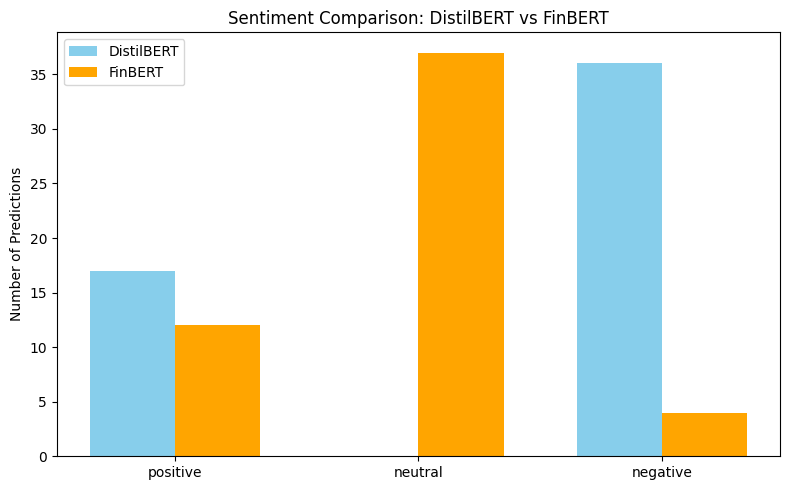

In [ ]:
import matplotlib.pyplot as plt

df = BERTs.toPandas()
valid_labels = ['positive', 'neutral', 'negative']

df['sentiment_label'] = df['sentiment_label'].astype(str).str.lower()
df['finbert_label'] = df['finbert_label'].astype(str).str.lower()

df_clean = df[df['sentiment_label'].isin(valid_labels) & df['finbert_label'].isin(valid_labels)]

distil_counts = df_clean['sentiment_label'].value_counts()
finbert_counts = df_clean['finbert_label'].value_counts()

labels = ['positive', 'neutral', 'negative']
distil_vals = [distil_counts.get(label, 0) for label in labels]
finbert_vals = [finbert_counts.get(label, 0) for label in labels]

x = range(len(labels))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x, distil_vals, width=width, label='DistilBERT', color='skyblue')
plt.bar([p + width for p in x], finbert_vals, width=width, label='FinBERT', color='orange')

plt.xticks([p + width/2 for p in x], labels)
plt.ylabel("Number of Predictions")
plt.title("Sentiment Comparison: DistilBERT vs FinBERT")
plt.legend()
plt.tight_layout()
plt.show()


# firebase


In [ ]:
for label in ["positive", "neutral", "negative"]:
    print(f"\n=== {label.upper()} Examples ===")
    samples = BERTs.filter(col("finbert_label") == label).limit(3).collect()
    if samples:
        for row in samples:
            print(f"\nTitle: {row.title}\nDistilBERT: {row.sentiment_label} ({row.sentiment_score:.2f})\nFinBERT: {row.finbert_label} ({row.finbert_score:.2f})")
    else:
        print(f"No {label} examples found")


=== POSITIVE Examples ===

Title: China Reviews U.S. Proposal to Scale Down Tariffs
DistilBERT: NEGATIVE (0.56)
FinBERT: positive (0.69)

Title: Why Crypto Leaders Are Feeling Optimistic About the Future: ‘The Crypto Revolution Is Happening’
DistilBERT: NEGATIVE (0.97)
FinBERT: positive (0.74)

Title: Bitcoin is back above $100,000
DistilBERT: POSITIVE (0.99)
FinBERT: positive (1.00)

=== NEUTRAL Examples ===

Title: 19-Year-Old to Plead Guilty to Hacking Charges After Data Breach of Millions of Schoolchildren
DistilBERT: NEGATIVE (1.00)
FinBERT: neutral (1.00)

Title: Pakistan Allocates 2,000 Megawatts of Electricity To Bitcoin Mining, AI Data Centres
DistilBERT: NEGATIVE (0.99)
FinBERT: neutral (1.00)

Title: Bitcoin price holds above $102,000 as BlackRock leads fund inflows
DistilBERT: NEGATIVE (1.00)
FinBERT: neutral (1.00)

=== NEGATIVE Examples ===

Title: DOGE Aide Involved in Dismantling Consumer Bureau Owns Stock in Companies That Could Benefit From Cuts
DistilBERT: NEGATIVE 

In [ ]:
docs = db.collection("news_analysis").get()
print(f"Total documents: {len(docs)}")

Total documents: 3


In [ ]:
from datetime import datetime

test_data = {
    "title": f"TEST at {datetime.now().strftime('%H:%M:%S')}",
    "sentiment_label": "POSITIVE",
    "sentiment_score": 0.95,
    "timestamp": firestore.SERVER_TIMESTAMP
}

try:
    db.collection("news_analysis").document(f"test_{datetime.now().timestamp()}").set(test_data)
    print("✅ New test document added")
except Exception as e:
    print(f"❌ Write failed: {str(e)}")

✅ New test document added


In [ ]:
print(f"Articles to process: {sentiment_df.count()}")  # Should match your NewsAPI fetch count

Articles to process: 69


In [ ]:
sentiment_df.select("title", "sentiment_label").show(5, truncate=False)

+-------------------------------------------------------------------------------------------------------+---------------+
|title                                                                                                  |sentiment_label|
+-------------------------------------------------------------------------------------------------------+---------------+
|19-Year-Old to Plead Guilty to Hacking Charges After Data Breach of Millions of Schoolchildren         |NEGATIVE       |
|Pakistan Allocates 2,000 Megawatts of Electricity To Bitcoin Mining, AI Data Centres                   |NEGATIVE       |
|Bitcoin price holds above $102,000 as BlackRock leads fund inflows                                     |NEGATIVE       |
|Jamie Dimon opens the door to bitcoin, warns against stagflation in wide-ranging remarks to investors  |POSITIVE       |
|El Salvador's Bitcoin Holdings Show $357 Million In Unrealized Profit As Bitcoin Closes At Record Highs|POSITIVE       |
+-----------------------

In [ ]:
print(f"Attempted to write {sentiment_df.count()} documents")

Attempted to write 69 documents


In [ ]:
for row in sentiment_df.collect():
    try:
        doc_ref = db.collection("news_analysis").document()
        doc_ref.set(row.asDict())
        print(f"Wrote: {row['title'][:50]}...")  # Log each write
    except Exception as e:
        print(f"Failed on {row['title'][:50]}...: {str(e)}")

Wrote: 19-Year-Old to Plead Guilty to Hacking Charges Aft...
Wrote: Pakistan Allocates 2,000 Megawatts of Electricity ...
Wrote: Bitcoin price holds above $102,000 as BlackRock le...
Wrote: Jamie Dimon opens the door to bitcoin, warns again...
Wrote: El Salvador's Bitcoin Holdings Show $357 Million I...
Wrote: Markets reel after Trump resumes tariff talks with...
Wrote: The Significance of Jamie Dimon’s Reluctant Bitcoi...
Wrote: Monero Likely Pumped 50% Due To Suspected $330 Mil...
Wrote: Wall Street's New Bitcoin Monster: Cantor's $4B Be...
Wrote: Bitcoin Mining Is No Longer Worth it...
Wrote: Tech Company With Chinese Ties Wants to Buy $300 M...
Wrote: Meta’s AI app is a nightmarish social feed...
Wrote: Raising ethics questions, top Trump meme coin inve...
Wrote: DOGE Aide Involved in Dismantling Consumer Bureau ...
Wrote: Michael Saylor’s new advice? 'Sell a tooth if you ...
Wrote: Peter Schiff Predicts 'Fireworks,' Says Michael Sa...
Wrote: This Bitcoin Encryption Comes from Rena

In [ ]:
import time
for row in sentiment_df.collect():
    doc_ref.set(row.asDict())
    time.sleep(0.1)

In [ ]:
docs = db.collection("news_analysis").get()
print("\n=== Current Firestore Documents ===")
for doc in docs:
    data = doc.to_dict()
    print(f"\nID: {doc.id}\nTitle: {data.get('title', 'MISSING')}\nTimestamp: {data.get('timestamp', 'MISSING')}")


=== Current Firestore Documents ===

ID: 01I0Jh6i6cgZYhUKv9Ff
Title: China Reviews U.S. Proposal to Scale Down Tariffs
Timestamp: MISSING

ID: 0pDHelQ60guxu1RNgp3F
Title: How Low Can Bitcoin Go?
Timestamp: MISSING

ID: 0py81NWep1ShxAaOaoIL
Title: Pakistan Allocates 2,000 Megawatts of Electricity To Bitcoin Mining, AI Data Centres
Timestamp: MISSING

ID: 0rUXwttGyKNYgc1JS5K9
Title: Markets reel after Trump resumes tariff talks with Canada
Timestamp: MISSING

ID: 2L1vXFfE9SJGEdSV6s2v
Title: Cryptocurrency boss's daughter escapes kidnap gang in Paris street
Timestamp: MISSING

ID: 3SEjvBTQUQpuJ0XeMoUI
Title: 'Crypto king' turned NYC townhouse into torture chamber to gain partner Bitcoin
Timestamp: MISSING

ID: 4tE0w2qu5yQvoEN9a1dq
Title: Jamie Dimon opens the door to bitcoin, warns against stagflation in wide-ranging remarks to investors
Timestamp: MISSING

ID: 69zuHl8taJ4eb1UcU8iW
Title: an alabama man who simswapped his way into the secs official x account enabling a fake etf announcem

In [ ]:
db.collection("news_analysis").document("test.doc").delete()

DatetimeWithNanoseconds(2025, 5, 27, 19, 59, 35, 179216, tzinfo=datetime.timezone.utc)

In [ ]:
docs = db.collection("news_analysis")\
         .order_by("timestamp", direction=firestore.Query.DESCENDING)\
         .limit(5)\
         .get()
for doc in docs:
    print(doc.to_dict())

{'sentiment_score': 0.87, 'title': 'TEST: Bitcoin price update', 'timestamp': '2025-05-27 19:29:26', 'sentiment_label': 'POSITIVE', 'source': 'automated_script'}
{'sentiment_score': 0.87, 'title': 'TEST: Bitcoin price update', 'timestamp': '2025-05-27 19:15:46', 'sentiment_label': 'POSITIVE', 'source': 'automated_script'}
{'sentiment_score': 0.95, 'title': 'TEST at 19:56:06', 'timestamp': DatetimeWithNanoseconds(2025, 5, 27, 19, 56, 6, 393000, tzinfo=datetime.timezone.utc), 'sentiment_label': 'POSITIVE'}
{'sentiment_score': 0.5, 'title': 'Test News', 'timestamp': DatetimeWithNanoseconds(2025, 5, 27, 19, 29, 52, 979000, tzinfo=datetime.timezone.utc), 'sentiment_label': 'NEUTRAL'}


In [ ]:
with open("requirements.txt", "w") as f:
    f.write("transformers\n")
    f.write("torch\n")
    f.write("pyspark\n")
    f.write("langdetect\n")
    f.write("firebase-admin\n")